# Social Media Sentiment Analysis

### Necessary libraries

In [94]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import confusion_matrix
import nltk 
import re
import string
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm
from collections import Counter


In [96]:
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\preet\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\preet\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\preet\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [61]:
df = pd.read_csv("sentimentdataset.csv")

In [6]:
df.drop(columns=['Unnamed: 0','Unnamed: 0.1'], inplace=True)

### Data Exploration

In [30]:
df.head()

,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [31]:
df.sample(3)

,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
545,Cheering for the underdog in the basketball fi...,Triumph,2022-06-20 21:00:00,BasketballFanUnderdogTriumph,Facebook,#Triumph #BasketballFinals,18.0,35.0,USA,2022,6,20,21
27,Quiet evening with a good book. ...,Positive,2023-01-23 19:45:00,BookLover,Instagram,#Reading #QuietTime,15.0,30.0,Australia,2023,1,23,19
188,Disgust at the corruption that stains society...,Disgust,2016-07-01 09:45:00,CorruptedHeart,Instagram,#Disgust #Corruption,7.0,15.0,UK,2016,7,1,9


In [32]:
df.describe()

,Retweets,Likes,Year,Month,Day,Hour
count,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000
mean,21.508197,42.901639,2020.471311,6.122951,15.497268,15.521858
std,7.061286,14.089848,2.802285,3.411763,8.474553,4.113414
min,5.000000,10.000000,2010.000000,1.000000,1.000000,0.000000
25%,17.750000,34.750000,2019.000000,3.000000,9.000000,13.000000
50%,22.000000,43.000000,2021.000000,6.000000,15.000000,16.000000
75%,25.000000,50.000000,2023.000000,9.000000,22.000000,19.000000
max,40.000000,80.000000,2023.000000,12.000000,31.000000,23.000000


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Text       732 non-null    object 
 1   Sentiment  732 non-null    object 
 2   Timestamp  732 non-null    object 
 3   User       732 non-null    object 
 4   Platform   732 non-null    object 
 5   Hashtags   732 non-null    object 
 6   Retweets   732 non-null    float64
 7   Likes      732 non-null    float64
 8   Country    732 non-null    object 
 9   Year       732 non-null    int64  
 10  Month      732 non-null    int64  
 11  Day        732 non-null    int64  
 12  Hour       732 non-null    int64  
dtypes: float64(2), int64(4), object(7)
memory usage: 74.5+ KB


In [68]:
df['Platform'].value_counts()

Platform
Instagram     258
Facebook      231
Twitter       128
Twitter       115
Name: count, dtype: int64

In [67]:
df.describe().loc[['min', '50%', 'mean', 'max', 'std']].T.style.background_gradient(axis=1)

,min,50%,mean,max,std
Retweets,5.000000,22.000000,21.508197,40.000000,7.061286
Likes,10.000000,43.000000,42.901639,80.000000,14.089848
Year,2010.000000,2021.000000,2020.471311,2023.000000,2.802285
Month,1.000000,6.000000,6.122951,12.000000,3.411763
Day,1.000000,15.000000,15.497268,31.000000,8.474553
Hour,0.000000,16.000000,15.521858,23.000000,4.113414


In [44]:
len_duplicated = len(df[df.duplicated(subset=['Text','Timestamp', 'Platform'])])

In [45]:
len(df) - len_duplicated

710

In [7]:
no_duplicated = df.drop_duplicates(subset=['Text', 'Timestamp', 'Platform','Country'], keep='first')

In [6]:
len(no_duplicated)

711

In [7]:
no_duplicated['Platform'].unique()

array([' Twitter  ', ' Instagram ', ' Facebook ', ' Twitter '],
      dtype=object)

In [34]:
no_duplicated=no_duplicated.drop_duplicates(['Country'])

In [35]:
no_duplicated.groupby(['Country']).Likes.agg([len, 'min', 'max']).sort_values(by='len', ascending=False)

,len,min,max
Country,,,
Australia,1,25.0,25.0
Thailand,1,70.0,70.0
Switzerland,1,45.0,45.0
Sweden,1,70.0,70.0
Spain,1,35.0,35.0
...,...,...,...
France,1,45.0,45.0
Denmark,1,40.0,40.0
Czech Republic,1,35.0,35.0


In [8]:
no_duplicated.groupby('Sentiment').Likes.agg([len, 'min', 'max']).sort_values(by='len', ascending=False).head(10)

,len,min,max
Sentiment,,,
Positive,44,15.0,60.0
Joy,42,30.0,80.0
Excitement,32,30.0,80.0
Happy,14,38.0,52.0
Neutral,14,35.0,50.0
Contentment,13,35.0,70.0
Sad,9,28.0,44.0
Gratitude,9,35.0,70.0
Embarrassed,8,32.0,60.0


# Data Visualization

Sentiment Distributions: 
Sentiment
Positive           44
Joy                42
Excitement         32
Neutral            14
Contentment        14
                   ..
Adrenaline          1
Harmony             1
ArtisticBurst       1
Radiance            1
Elegance            1
Name: count, Length: 279, dtype: int64


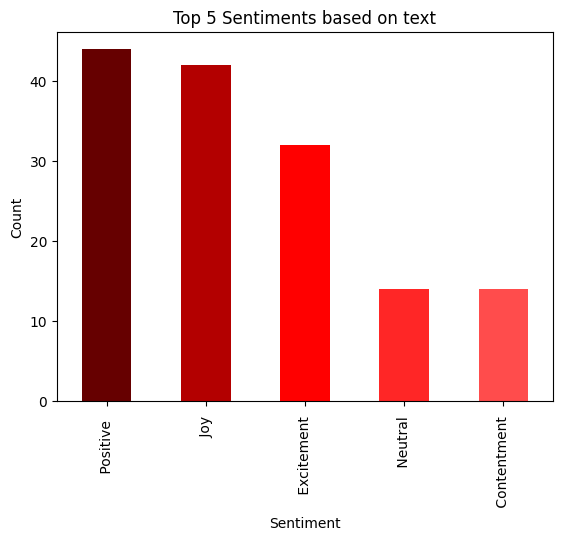

In [127]:
sentiment_distribution = df['Sentiment'].value_counts()
print("Sentiment Distributions: ")
print(sentiment_distribution)

colors = ['#660000', '#b30000', '#ff0000', '#ff2626', '#ff4c4c']
df['Sentiment'].value_counts().nlargest(5).plot(kind='bar', color = colors)
plt.title('Top 5 Sentiments based on text')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

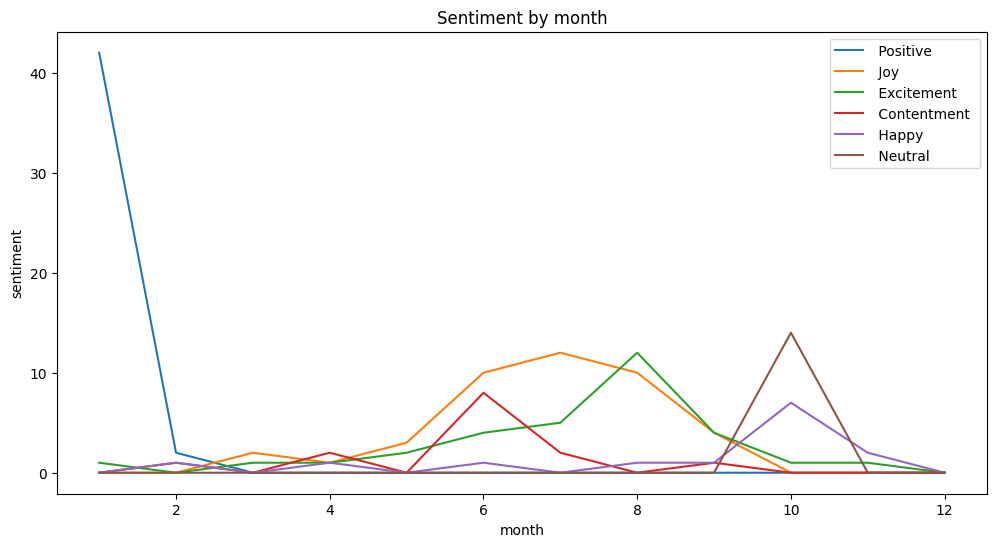

In [80]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.month

sentiment_by_month = df.groupby(['Month', 'Sentiment']).size().unstack(fill_value=0)
top_sentiments = sentiment_by_month.sum().nlargest(6).index
sentiment_by_month = sentiment_by_month[top_sentiments]

plt.figure(figsize=(12,6))
for sentiment in sentiment_by_month.columns:
    plt.plot(sentiment_by_month.index, sentiment_by_month[sentiment], label=sentiment)

plt.title("Sentiment by month")
plt.xlabel("month")
plt.ylabel('sentiment')
plt.legend()
plt.grid(False)
plt.show()

In [21]:
df=df.drop_duplicates()

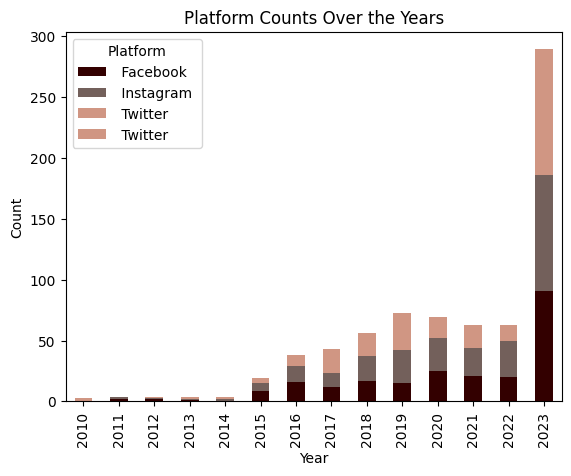

In [33]:
platform_counts = df.groupby(['Year', 'Platform']).size().unstack(fill_value=0)

# Plotting
color_palette = ['#330000', '#73605B', '#D09683', '#D09683']
platform_counts.plot(kind='bar', stacked=True, color = color_palette)
plt.title('Platform Counts Over the Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Platform')
plt.show()

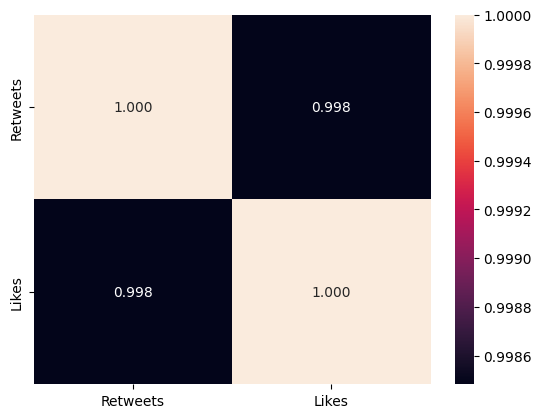

In [7]:
engagement_metrics = df[['Retweets', 'Likes']]
corr = engagement_metrics.corr()
sns.heatmap(corr, annot=True, fmt = '.3f')
plt.show()

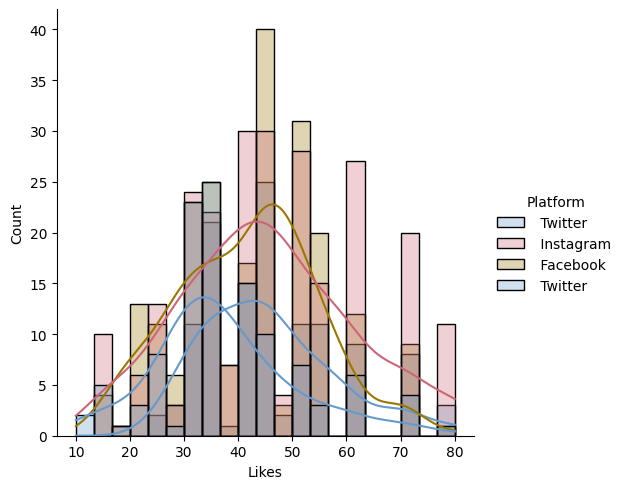

In [73]:
sns.displot(data=no_duplicated[['Platform','Likes']], x="Likes", hue="Platform", 
            palette = ["#6699CC", '#CC6677', '#997700', '#6699CC'], 
            alpha=0.3,
            kde=True)
plt.show()

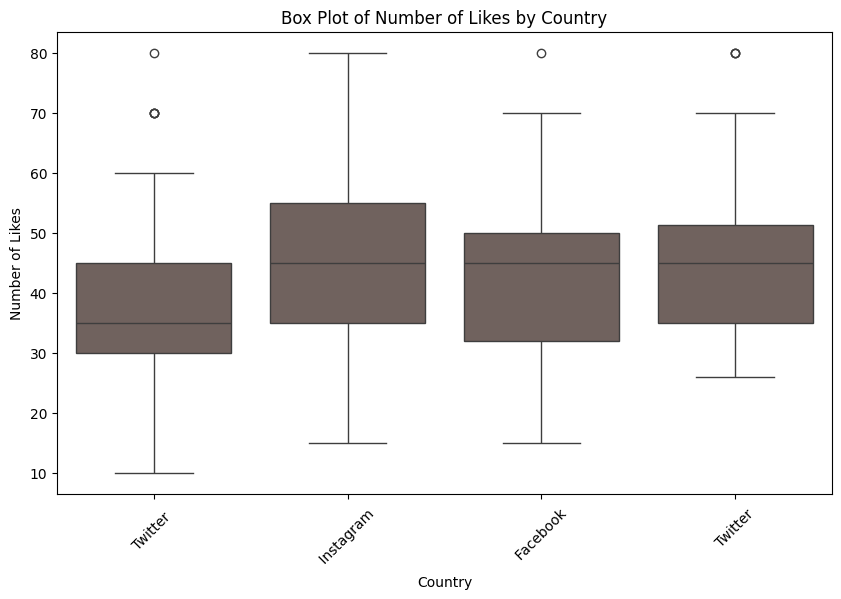

In [139]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Platform', y='Likes', data=df, color='#73605B')
plt.xticks(rotation=45) 

plt.xlabel('Country')
plt.ylabel('Number of Likes')
plt.title('Box Plot of Number of Likes by Country')
plt.show()

In [13]:
no_duplicated = df.drop_duplicates()

In [24]:
no_duplicated.groupby(['Country']).Likes.agg([len, min, max]).sort_values(by='len', ascending=False)

C:\Users\preet\AppData\Local\Temp\ipykernel_9424\3385004156.py:1: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  no_duplicated.groupby(['Country']).Likes.agg([len, min, max]).sort_values(by='len', ascending=False)
C:\Users\preet\AppData\Local\Temp\ipykernel_9424\3385004156.py:1: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  no_duplicated.groupby(['Country']).Likes.agg([len, min, max]).sort_values(by='len', ascending=False)


,len,min,max
Country,,,
USA,59,28.0,70.0
USA,51,24.0,80.0
UK,49,27.0,70.0
Canada,44,31.0,70.0
Australia,36,20.0,60.0
...,...,...,...
Netherlands,1,45.0,45.0
Norway,1,45.0,45.0
Peru,1,55.0,55.0


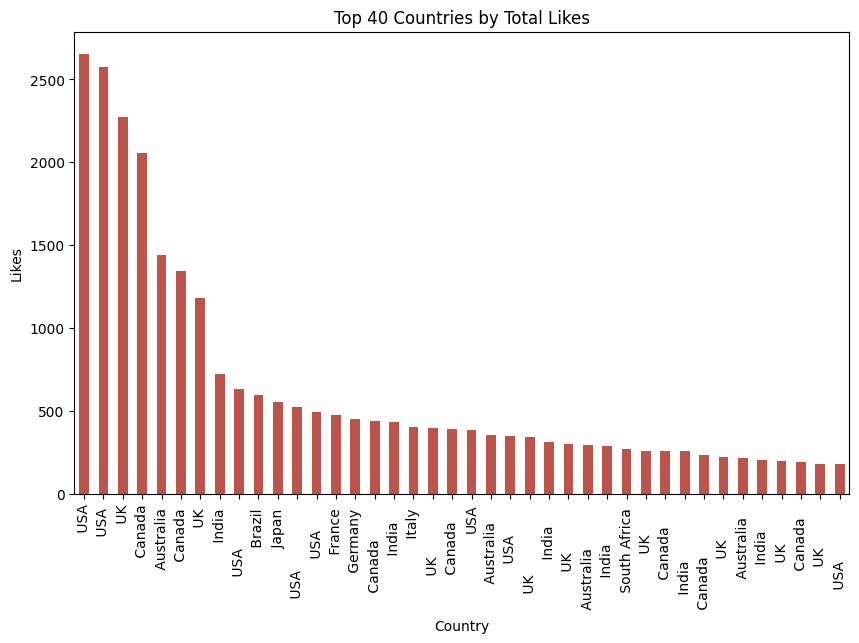

In [129]:
likes_per_country = no_duplicated.groupby(['Country']).Likes.sum().sort_values(ascending=False)
top_40_countries = likes_per_country.head(40)

top_40_countries.plot(kind='bar', color='#BC544B', figsize=(10, 6))
plt.ylabel('Likes')
plt.title('Top 40 Countries by Total Likes')
plt.xlabel('Country')
plt.show()

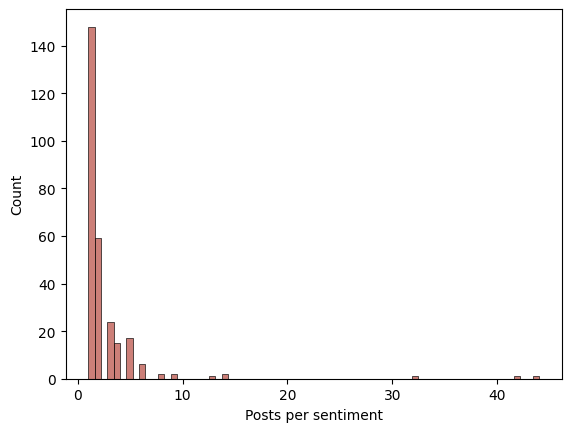

In [130]:
sns.histplot(no_duplicated.groupby('Sentiment').Likes.agg(len), 
             color='#BC544B', edgecolor='k',
            )
plt.xlabel('Posts per sentiment')
plt.show()

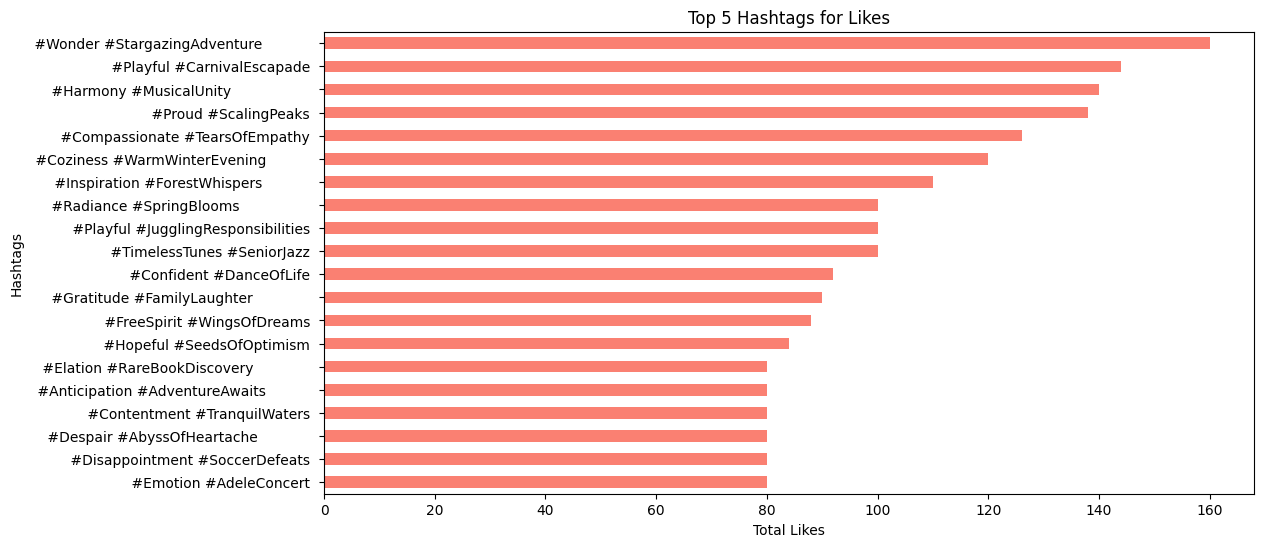

In [35]:
hashtags_stats = df.groupby('Hashtags').agg({'Retweets': 'sum', 'Likes': 'sum'})
top_likes = hashtags_stats.nlargest(20, 'Likes')
top_likes = top_likes.sort_values(by='Likes', ascending=True)


plt.figure(figsize=(12, 6))
top_likes['Likes'].plot(kind='barh', color='salmon')
plt.title('Top 5 Hashtags for Likes')
plt.xlabel('Total Likes')
plt.ylabel('Hashtags')
plt.show()

In [99]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\s+', ' ', text.strip())
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)  
    text = " ".join(text.split())
    tokens = word_tokenize(text)
    
    cleaned_tokens = [stemmer.stem(token) for token in tokens if token.lower() not in stop_words]
   
    cleaned_text = ' '.join(cleaned_tokens)
    
    return cleaned_text

df["Clean_Text"] = df["Text"].apply(clean)

In [103]:
df1 = df.copy()

In [118]:
analyzer = SentimentIntensityAnalyzer()

df1['Vader_Score'] = df1['Clean_Text'].apply(lambda text: analyzer.polarity_scores(text)['compound'])

df1['Sentiment'] = df1['Vader_Score'].apply(lambda score: 'positive' if score >= 0.05 else ('negative' if score <= -0.05 else 'neutral'))

print(df1[['Clean_Text', 'Vader_Score', 'Sentiment']].head())

                     Clean_Text  Vader_Score Sentiment
0         enjoy beauti day park       0.4939  positive
1          traffic terribl morn       0.0000   neutral
2           finish amaz workout       0.0000   neutral
3   excit upcom weekend getaway       0.0000   neutral
4  tri new recip dinner tonight       0.0000   neutral


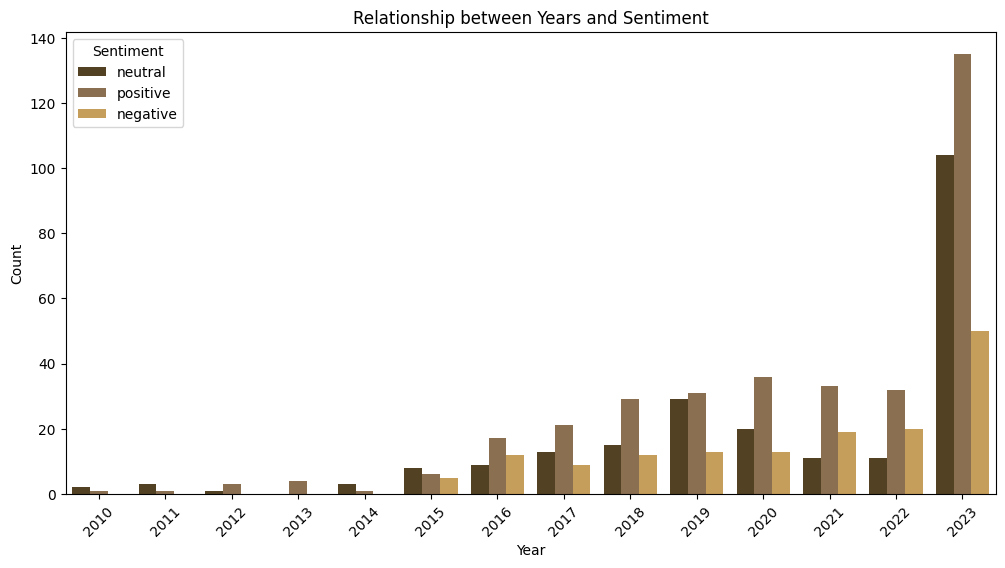

In [135]:
color_palette = ['#5a431b', '#937047', '#d6a34a']
plt.figure(figsize=(12, 6))
sns.countplot(x='Year', hue='Sentiment', data=df1, palette=color_palette)
plt.title('Relationship between Years and Sentiment')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


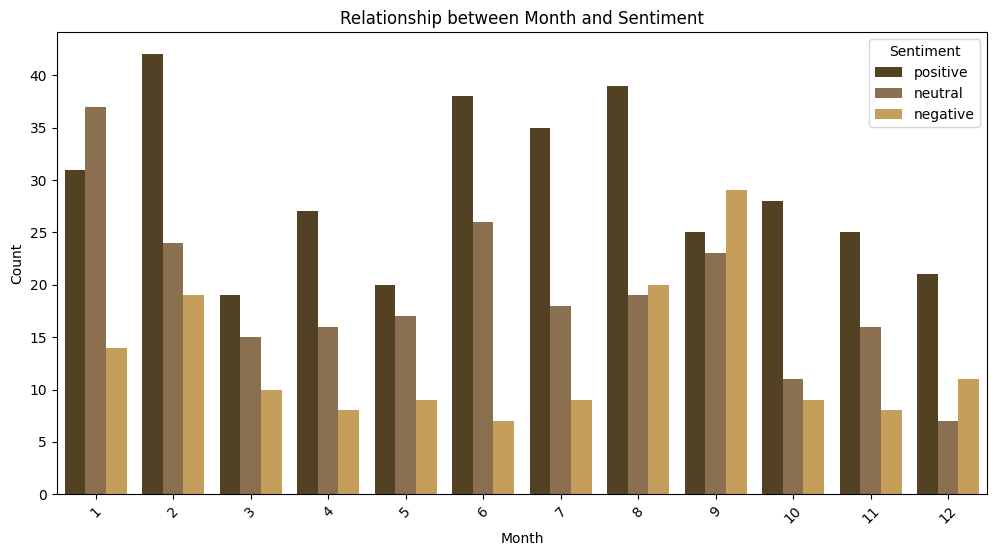

In [137]:
color_palette = ['#5a431b', '#937047', '#d6a34a']
plt.figure(figsize=(12, 6))
sns.countplot(x='Month', hue='Sentiment', data=df1, palette=color_palette)
plt.title('Relationship between Month and Sentiment')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

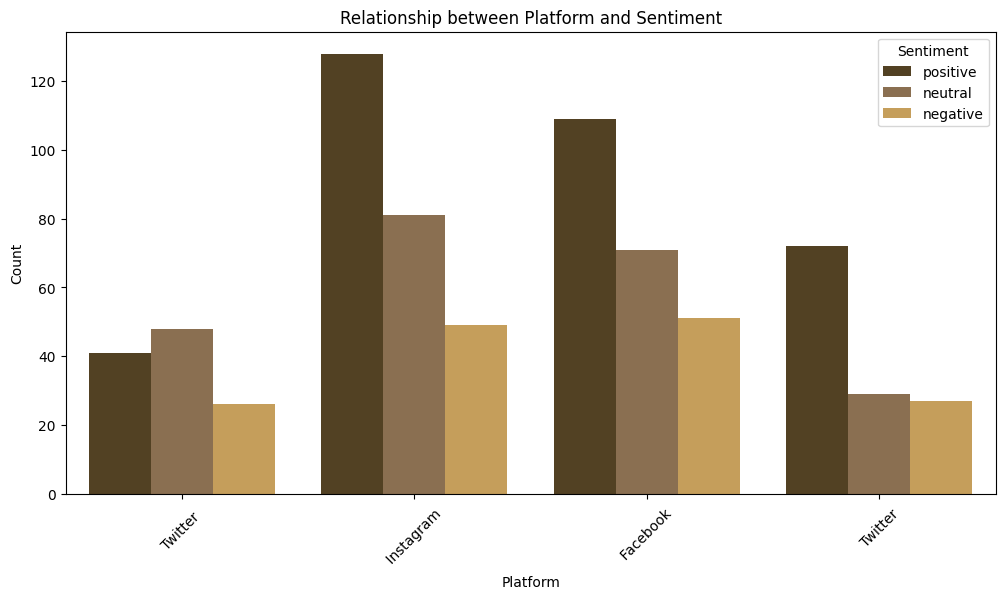

In [138]:
color_palette = ['#5a431b', '#937047', '#d6a34a']
plt.figure(figsize=(12, 6))
sns.countplot(x='Platform', hue='Sentiment', data=df1, palette=color_palette)
plt.title('Relationship between Platform and Sentiment')
plt.xlabel('Platform')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [115]:
df1['temp_list'] = df1['Clean_Text'].apply(lambda x: str(x).split())
top_words = Counter([item for sublist in df1['temp_list'] for item in sublist])
top_words_df = pd.DataFrame(top_words.most_common(20), columns=['Common_words', 'count'])

top_words_df.style.background_gradient(cmap='Blues')

,Common_words,count
0,new,43
1,life,37
2,challeng,34
3,joy,31
4,danc,30
5,day,29
6,feel,29
7,like,28
8,dream,28
9,moment,27


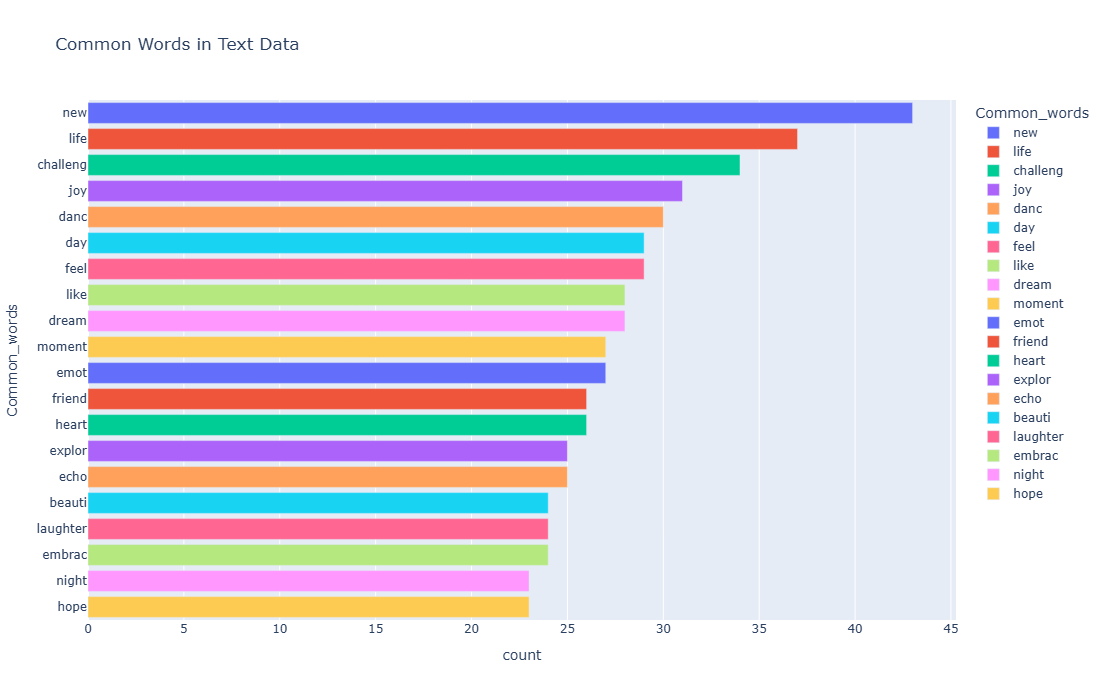

In [104]:
df1['temp_list'] = df1['Clean_Text'].apply(lambda x: str(x).split())
top_words = Counter([item for sublist in df1['temp_list'] for item in sublist])
top_words_df = pd.DataFrame(top_words.most_common(20), columns=['Common_words', 'count'])

fig = px.bar(top_words_df,
            x="count",
            y="Common_words",
            title='Common Words in Text Data',
            orientation='h',
            width=700,
            height=700,
            color='Common_words')

fig.show()

In [119]:
Positive_sent = df1[df1['Sentiment'] == 'positive']
Negative_sent = df1[df1['Sentiment'] == 'negative']
Neutral_sent = df1[df1['Sentiment'] == 'neutral']

In [120]:
top = Counter([item for sublist in df1[df1['Sentiment'] == 'positive']['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,joy,30
1,friend,24
2,laughter,24
3,new,21
4,challeng,20
5,life,20
6,hope,20
7,dream,20
8,embrac,19
9,like,19


In [121]:
top = Counter([item for sublist in df1[df1['Sentiment'] == 'neutral']['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
temp_positive.style.background_gradient(cmap='Blues')

,Common_words,count
0,new,22
1,explor,13
2,excit,12
3,life,12
4,beauti,12
5,night,12
6,danc,12
7,attend,11
8,seren,11
9,feel,10


In [122]:
top = Counter([item for sublist in df1[df1['Sentiment'] == 'negative']['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
temp_positive.style.background_gradient(cmap='Reds')

,Common_words,count
0,despair,14
1,lost,14
2,emot,13
3,feel,11
4,bitter,10
5,storm,10
6,day,9
7,like,9
8,grief,8
9,heart,8
